In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import pandas as pd

from __future__ import print_function
import os
from functools import partial
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

# Helper functions for TF Graph visualization (imported).
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### Load notMNIST Data

In [2]:
with np.load("notMNIST.npz") as data:
    Data, Target = data ["images"], data["labels"]
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data = Data[randIndx]/255.
    Target = Target[randIndx]
    
    trainData, trainTarget = np.reshape(Data[:15000], (15000,784)), Target[:15000]
    b= np.zeros((15000,10))
    b[np.arange(15000), trainTarget] = 1
    trainTarget = b
    
    validData, validTarget = np.reshape(Data[15000:16000], (1000,784)), Target[15000:16000]
    b= np.zeros((1000,10))
    b[np.arange(1000), validTarget] = 1
    validTarget = b
    
    testData, testTarget = np.reshape(Data[16000:], (2724,784)), Target[16000:]
    b= np.zeros((2724,10))
    b[np.arange(2724), testTarget] = 1
    testTarget = b

### Weight Visualization Function Definition

In [3]:
def visualize_weights(label, weights):
    # display 1st layer weights as an image
    SEPERATOR = 1
    NODES_IN_LENGTH = 20
    NODES_IN_WIDTH = 25

    LENGTH = NODES_IN_LENGTH * 28 + (NODES_IN_LENGTH + 1) * SEPERATOR
    WIDTH = NODES_IN_WIDTH * 28 + (NODES_IN_WIDTH + 1) * SEPERATOR
    
    W_1_np = sess.run(weights)
    img = np.full([LENGTH, WIDTH], np.amin(W_1_np), dtype=np.float32)
    

    for nodes_i in range(NODES_IN_LENGTH):
        for nodes_j in range(NODES_IN_WIDTH):
            for in_weight_i in range(28):
                for in_weight_j in range(28):
                    img_i = nodes_i * (28 + SEPERATOR) + SEPERATOR + in_weight_i
                    img_j = nodes_j * (28 + SEPERATOR) + SEPERATOR + in_weight_j

                    W_1_j = nodes_i * NODES_IN_WIDTH + nodes_j
                    W_1_i = in_weight_i * 28 + in_weight_j

                    img[img_i, img_j] = W_1_np[W_1_i, W_1_j]



    plt.figure(dpi=10, tight_layout=True, frameon=False, figsize=(LENGTH, WIDTH))
    plt.imshow(img, cmap='gray')
    plt.savefig('2.2.2-weight-visualization'+label+'.png', bbox_inches='tight')

### Model Definition

In [4]:
def neural_net_block(prev_layer, layer_size):
    PREV_LAYER_DIM = prev_layer.get_shape().as_list()[1]
    XAVIER_INIT_STDDEV = tf.cast(3 / (layer_size + PREV_LAYER_DIM), tf.float32)

    # initialize variables
    layer_weights = tf.Variable(tf.random_normal([PREV_LAYER_DIM, layer_size], stddev=XAVIER_INIT_STDDEV), name='weights')
    layer_biases = tf.Variable(tf.zeros([1, layer_size]), name='bias')

    # calculate output
    layer_z = tf.matmul(prev_layer, layer_weights) + layer_biases
    
    # return all in order to have external handle for variables
    return layer_z, layer_weights, layer_biases

Epoch 500 / 500 : 0.505822 loss
[[  3.48863835e-14   2.15852545e-08   1.05217689e-10   7.34640810e-13
    1.89621289e-07   9.99999285e-01   5.06144602e-07   6.28424424e-09
    4.63414658e-08   3.69523578e-11]
 [  7.76447919e-08   1.23092958e-09   1.92984365e-12   6.15091622e-09
    2.79861984e-11   5.13490778e-11   1.69511610e-11   8.48428451e-14
    6.39573787e-04   9.99360383e-01]
 [  2.06756994e-08   3.12870618e-08   4.44254286e-11   1.67869776e-02
    2.16313703e-11   1.40977136e-07   9.21583165e-08   6.38308642e-11
    7.37534883e-03   9.75837469e-01]
 [  1.22004969e-03   2.22094004e-05   1.82503409e-05   4.43805679e-04
    2.58770335e-04   2.54901648e-02   8.25571769e-04   9.49383620e-03
    2.25495309e-01   7.36732066e-01]
 [  1.27896741e-02   1.07046120e-01   3.91720980e-02   7.66262636e-02
    8.52670819e-02   1.89182777e-02   4.55906183e-01   6.21176977e-03
    1.74047783e-01   2.40147915e-02]
 [  1.45689867e-07   4.67588143e-06   9.57645607e-05   1.16107856e-06
    4.8119682

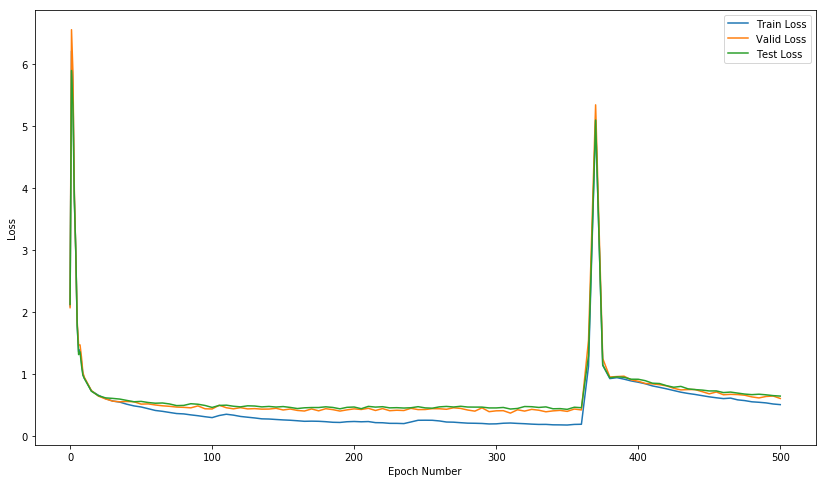

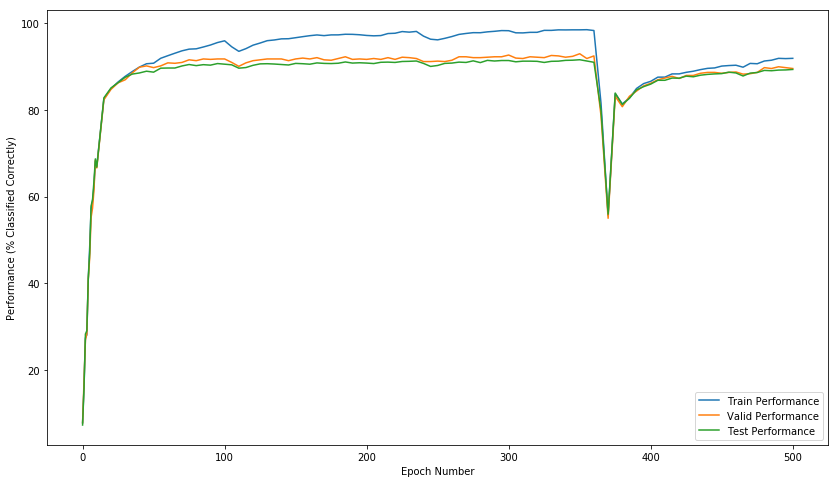

Epoch 500 / 500 : Model saved in file  .\model-2.2.2-v1.ckpt


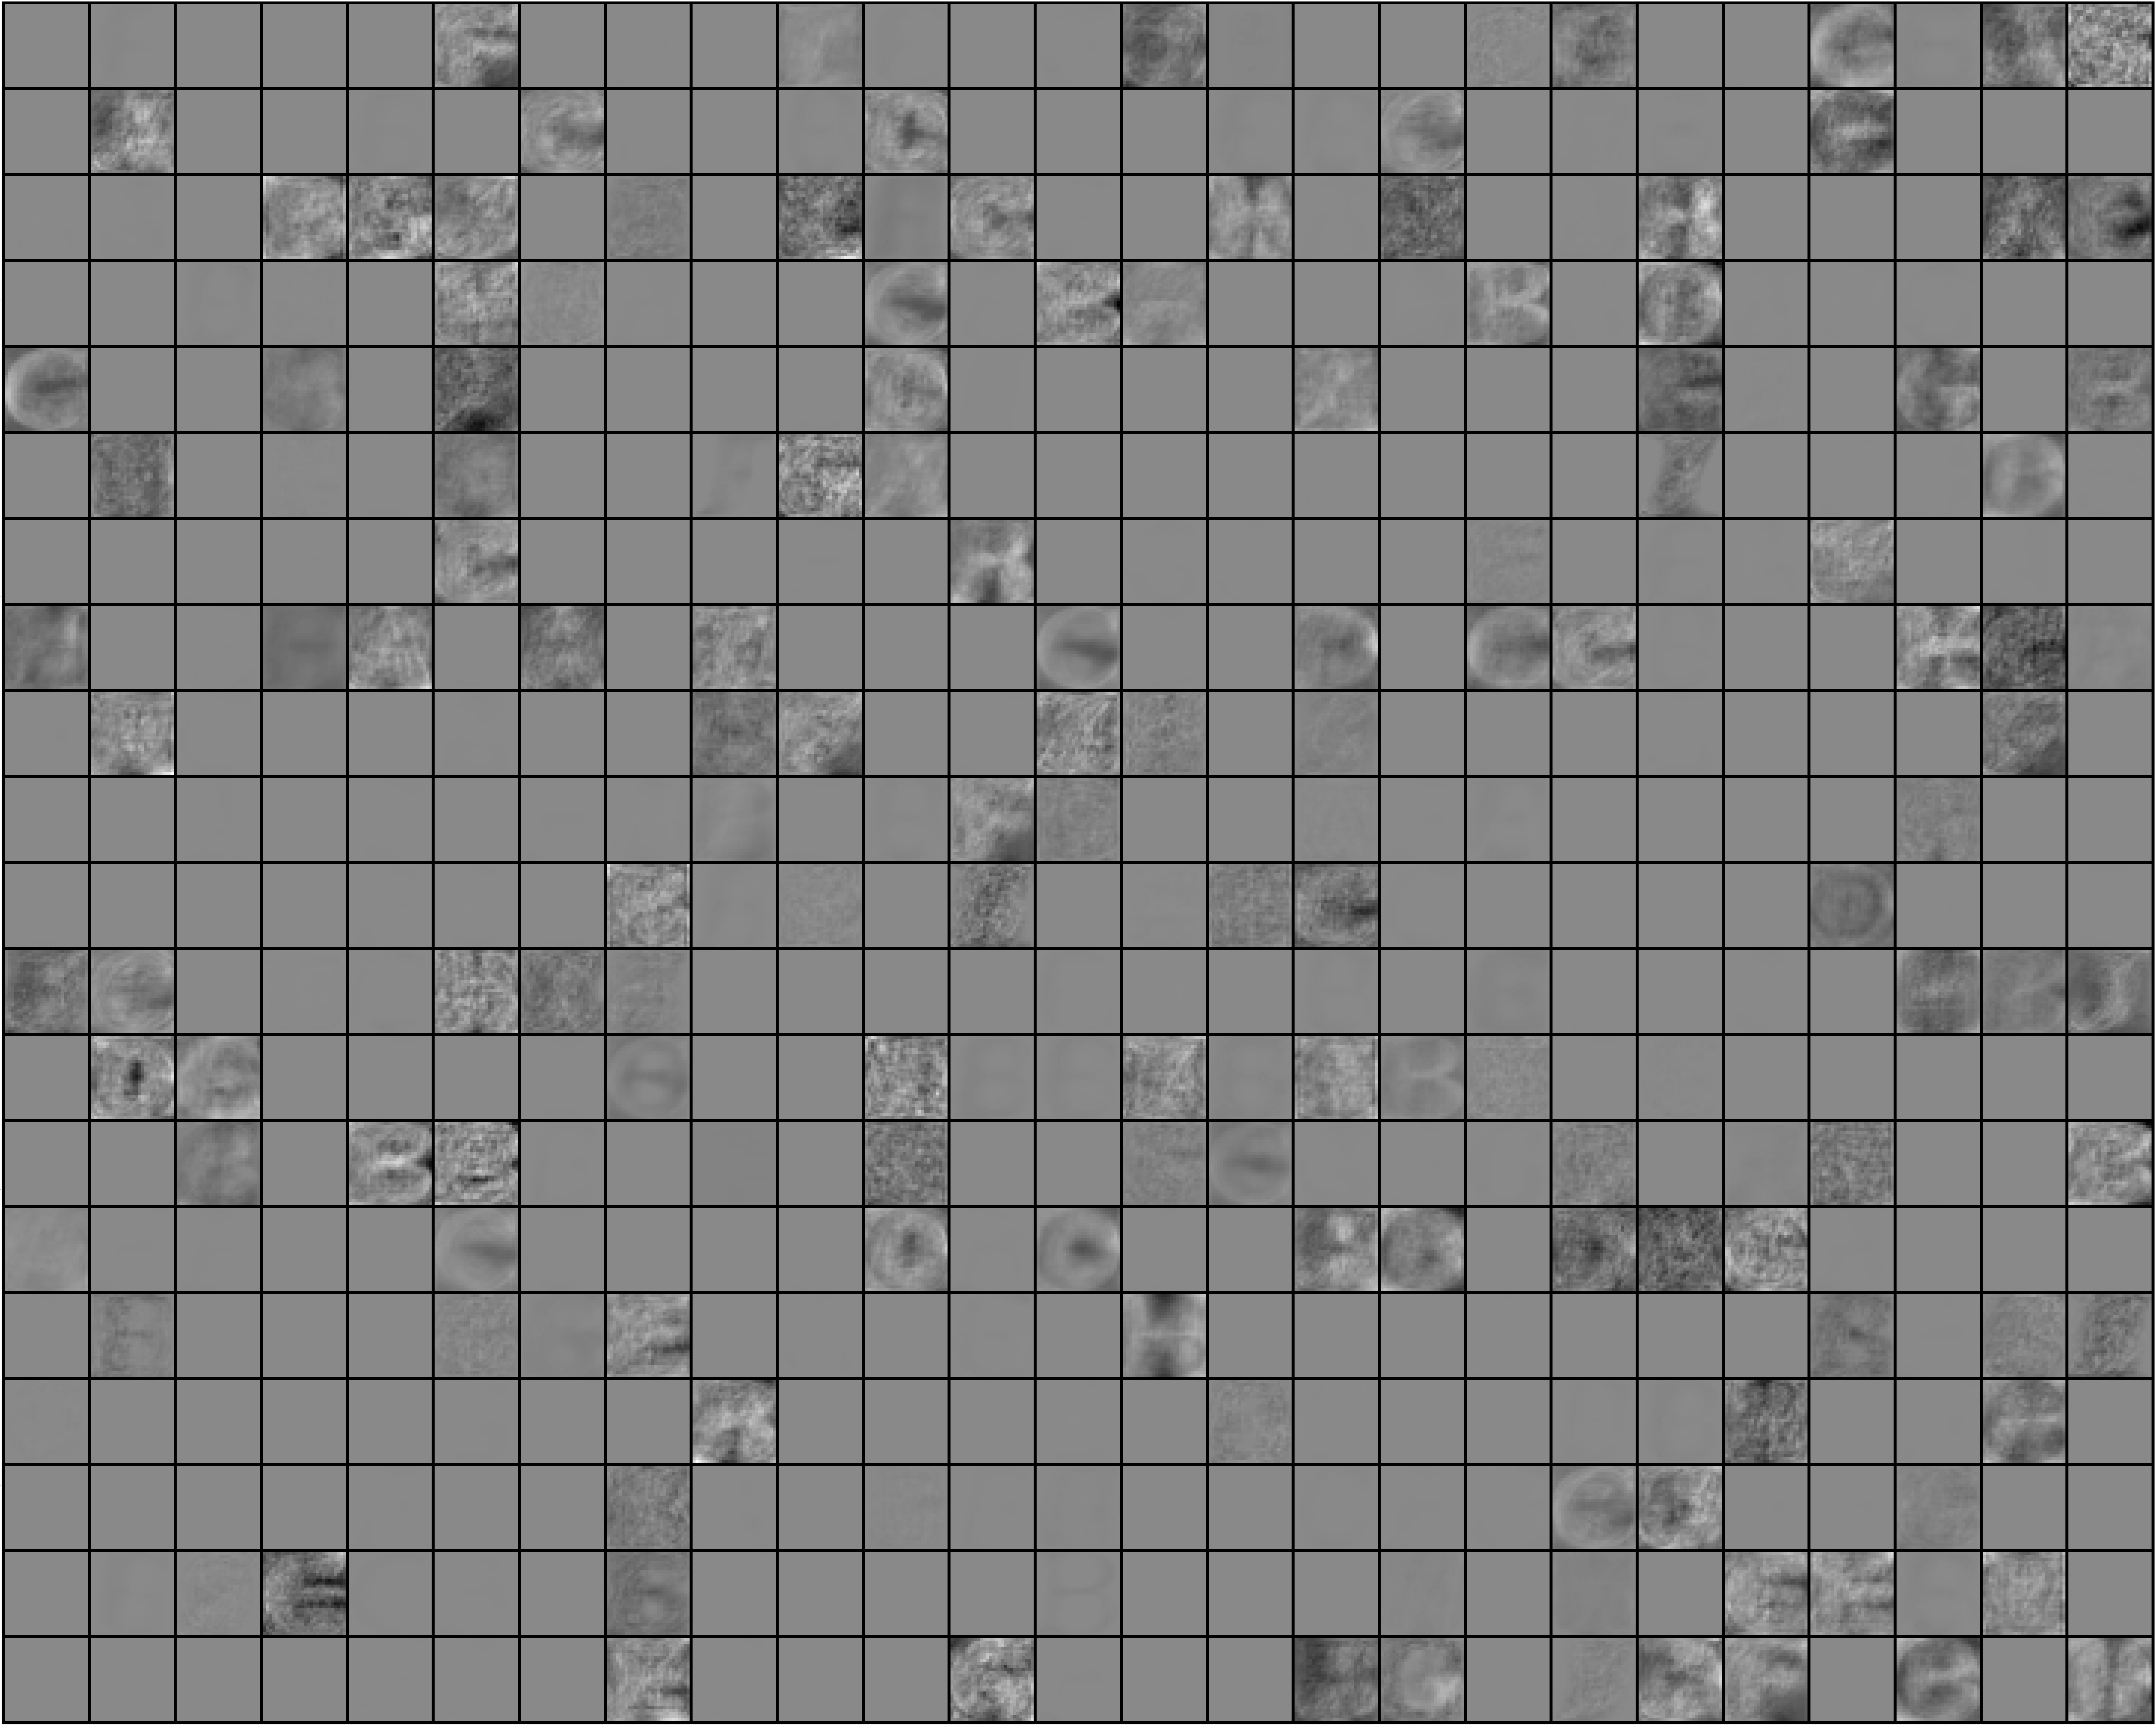

In [15]:
# parameters
MAX_NUM_EPOCHS = 500
PRINT_FREQUENCY = 0.01
SAVE_FREQUENCY = 0.25
η = 0.01
λ = 0.0003
input_shape = [None, 784]
label_shape = [None, 10]

# profiles
train_loss_profile = []
valid_loss_profile = []
test_loss_profile = []
train_performance_profile = []
valid_performance_profile = []
test_performance_profile = []
epoch_profile = []

# reset for graph visualization
# tf.reset_default_graph()

# placeholders
x = tf.placeholder(tf.float32, shape=input_shape, name='x')
y = tf.placeholder(tf.float32, shape=label_shape, name='y')

# prediction
z_1, W_1, b_1 = neural_net_block(x, 1000)
z_2, W_2, b_2 = neural_net_block(tf.nn.dropout(tf.nn.relu(z_1), 0.5), label_shape[1])
y_hat = z_2
y_hat_out = tf.nn.softmax(tf.matmul(tf.nn.relu(z_1), W_2) + b_2)

# loss
cross_entropy_loss = tf.reduce_mean(tfcross_entropy_loss.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat)) \
                                    + (λ / 2) * (tf.reduce_sum(tf.square(W_1)) + tf.reduce_sum(tf.square(W_2)))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=η)
train = optimizer.minimize(loss=cross_entropy_loss)

# init
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
                         
# begin training
for epoch in range(MAX_NUM_EPOCHS + 1):
    train_res = sess.run(train, feed_dict={x:trainData, y:trainTarget})

    # print progress periodically
    if epoch % (MAX_NUM_EPOCHS * PRINT_FREQUENCY) == 0 or epoch < 10:
        # check overall loss 
        train_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:trainData, y:trainTarget}))
        valid_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:validData, y:validTarget}))
        test_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:testData, y:testTarget}))

        # check overall performance
        train_y_hat = sess.run(y_hat_out, feed_dict={x:trainData, y:trainTarget})
        train_performance_profile.append(np.sum(np.all(np.rint(train_y_hat) == trainTarget, axis=1)) / trainTarget.shape[0] * 100)
        valid_y_hat = sess.run(y_hat_out, feed_dict={x:validData, y:validTarget})
        valid_performance_profile.append(np.sum(np.all(np.rint(valid_y_hat) == validTarget, axis=1)) / validTarget.shape[0] * 100)
        test_y_hat = sess.run(y_hat_out, feed_dict={x:testData, y:testTarget})
        test_performance_profile.append(np.sum(np.all(np.rint(test_y_hat) == testTarget, axis=1)) / testTarget.shape[0] * 100)
        
        # append epoch profile
        epoch_profile.append(epoch)
        
        # clear plot
        clear_output(wait=True)
        print('Epoch', epoch, '/', MAX_NUM_EPOCHS, ':', train_loss_profile[-1], 'loss')
        print(train_y_hat[:10])
        print(trainTarget[:10])
        
        # plot losses
        plt.figure(figsize=(14, 8))
        plt.plot(epoch_profile, train_loss_profile, label='Train Loss')
        plt.plot(epoch_profile, valid_loss_profile, label='Valid Loss')
        plt.plot(epoch_profile, test_loss_profile, label='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch Number')
        plt.legend()
        plt.savefig('2.2.2-Loss.png')
        plt.show()
        
        # plot performance
        plt.figure(figsize=(14, 8))
        plt.plot(epoch_profile, train_performance_profile, label='Train Performance')
        plt.plot(epoch_profile, valid_performance_profile, label='Valid Performance')
        plt.plot(epoch_profile, test_performance_profile, label='Test Performance')
        plt.ylabel('Performance (% Classified Correctly)')
        plt.xlabel('Epoch Number')
        plt.legend()
        plt.savefig('2.2.2-Performance.png')
        plt.show()
        
    # save progress periodically
    if epoch % round(MAX_NUM_EPOCHS * SAVE_FREQUENCY) == 0:
        save_path = saver.save(sess, ".\model-2.2.2-v1.ckpt")
        visualize_weights(str(epoch), W_1)
        print('Epoch', epoch, '/', MAX_NUM_EPOCHS, ': Model saved in file ', save_path)
        
        
# visualize the computation graph
# show_graph(tf.get_default_graph().as_graph_def())

The model has been trained, and the constituent weights have been visualized. One can see the outlines of the letters from the notMNIST dataset in the weight values.